In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
import pandas as pd
import xarray as xr
import matplotlib.pyplot as plt

import joblib
import glob
import warnings

from mpl_toolkits.basemap import Basemap


sys.path.append('/home/freimax/msc_thesis/scripts/helpers/')
import helper
import data_preprocessing_helpers

In [3]:
def get_climatology(season, startyear=2010):
    path = '/net/helium/atmosdyn/freimax/data_msc/ERA5/bcp_climatology'
    files = sorted(glob.glob(f'{path}/*_{season}.nc'))

    # List to store the datasets
    datasets = []

    # Loop through the files and add a time coordinate
    for i, file in enumerate(files):
        ds_1yr = xr.open_dataset(file)
        
        # Create a time coordinate and add it to current dataset
        time_coord = xr.DataArray(pd.to_datetime([f'{int(startyear) + i}-01-01']), dims='time')
        ds_1yr = ds_1yr.assign_coords(time=time_coord)
        # Append current year to list of datasets    
        datasets.append(ds_1yr)

        ds = xr.concat(datasets, dim='time')
    # Concatenate along the time dimension
    return ds.mean(dim='time')

In [4]:
# path = '/net/helium/atmosdyn/freimax/data_msc/ERA5/bcp_climatology'
# files = sorted(glob.glob(f'{path}/*_DJF.nc'))

# # List to store the datasets
# datasets = []

# # Loop through the files and add a time coordinate
# for i, file in enumerate(files):
#     ds_1yr = xr.open_dataset(file)
    
#     # Create a time coordinate and add it to current dataset
#     time_coord = xr.DataArray(pd.to_datetime([f'{1990 + i}-01-01']), dims='time')
#     ds_1yr = ds_1yr.assign_coords(time=time_coord)
#     # Append current year to list of datasets    
#     datasets.append(ds_1yr)
    
# # Concatenate along the time dimension
# ds_djf = xr.concat(datasets, dim='time')


In [5]:
start_year='2010'
ds_djf = get_climatology(season='DJF', startyear=start_year)
ds_jja = get_climatology(season='JJA', startyear=start_year)

In [6]:
## Save datasets
ds_djf.to_netcdf(f'/net/helium/atmosdyn/freimax/data_msc/ERA5/bcp_climatology/season_avg/DJF_{start_year}_2020')
ds_jja.to_netcdf(f'/net/helium/atmosdyn/freimax/data_msc/ERA5/bcp_climatology/season_avg/JJA_{start_year}_2020')

In [7]:
da_landsea = xr.load_dataarray('/net/thermo/atmosdyn/era5/const/LANDSEA.nc')
da_landsea = da_landsea.sel(lat=slice(0,90)).squeeze()

In [8]:
ds_djf_sea = xr.where(da_landsea==0, ds_djf, np.nan)
ds_jja_sea = xr.where(da_landsea==0, ds_jja, np.nan)

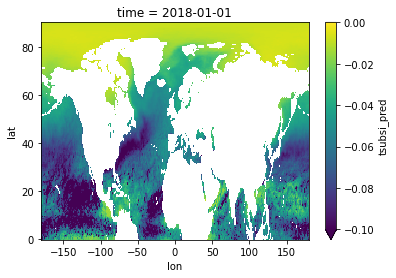

In [9]:
ds_djf_sea.sel(level=slice(950,500)).mean(dim='level').tsubsi_pred.plot(vmax= 0, vmin=-0.1)
# plt.show()
# ds_jja_sea.sel(level=slice(950,750)).nanmean(dim='level').tsubsi_pred.plot(vmax= 0, vmin=-0.1)

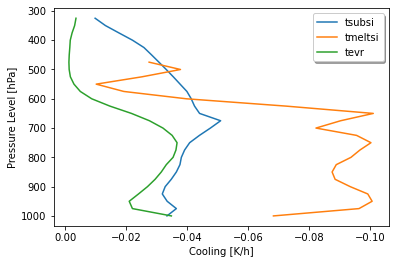

In [48]:
fig, ax = plt.subplots()

tsubsi_avg = ds_djf.tsubsi_pred.mean(dim=['lon','lat'])
tmeltsi_avg = ds_djf.tmeltsi_pred.mean(dim=['lon','lat'])
tevr_avg = ds_djf.tevr_pred.mean(dim=['lon','lat'])

ax.plot(tsubsi_avg, ds_djf.level, label='tsubsi')
ax.plot(tmeltsi_avg, ds_djf.level, label='tmeltsi')
ax.plot(tevr_avg, ds_djf.level, label='tevr')
ax.set_ylabel('Pressure Level [hPa]')
ax.set_xlabel('Cooling [K/h]')
ax.legend(shadow=True)

ax.invert_xaxis()
ax.invert_yaxis()

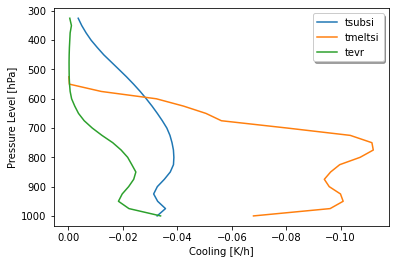

In [50]:
fig, ax = plt.subplots()

tsubsi_avg = ds_djf.tsubsi_pred.sel(lat=slice(30,90)).mean(dim=['lon','lat'])
tmeltsi_avg = ds_djf.tmeltsi_pred.sel(lat=slice(30,90)).mean(dim=['lon','lat'])
tevr_avg = ds_djf.tevr_pred.sel(lat=slice(30,90)).mean(dim=['lon','lat'])

ax.plot(tsubsi_avg, ds_djf.level, label='tsubsi')
ax.plot(tmeltsi_avg, ds_djf.level, label='tmeltsi')
ax.plot(tevr_avg, ds_djf.level, label='tevr')
ax.set_ylabel('Pressure Level [hPa]')
ax.set_xlabel('Cooling [K/h]')
ax.legend(shadow=True)

ax.invert_xaxis()
ax.invert_yaxis()

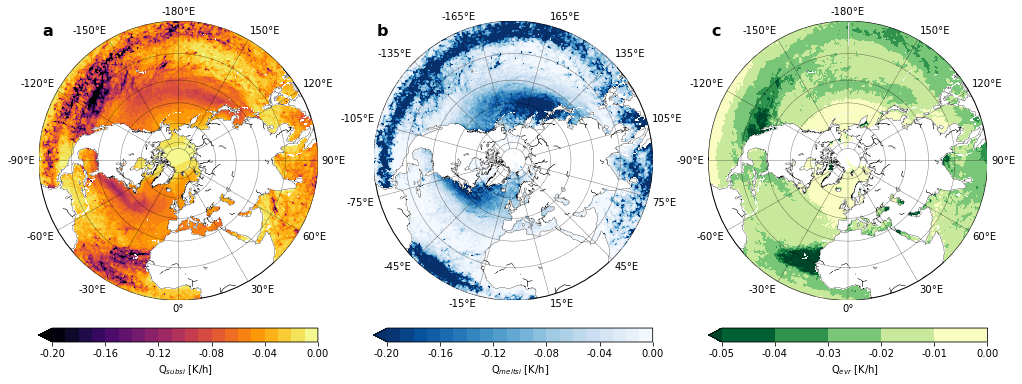

In [49]:

# def plot_map(save=True, plot_counter_example=True):

fig, ax = plt.subplots(ncols=3, figsize=(17,8))

# fig.suptitle(f'Trajectories that are cooled by at least {cutoff} K/48h')

data = [ds_djf_sea['tsubsi_pred'].sel(level=slice(950,600)).mean(dim='level')  , 
        ds_djf_sea['tmeltsi_pred'].sel(level=slice(950,600)).mean(dim='level') , 
        ds_djf_sea['tevr_pred'].sel(level=slice(950,600)).mean(dim='level')    ,
        ]

cbar_label = [r'Q$_{subsi}$ [K/h]', r'Q$_{meltsi}$ [K/h]', r'Q$_{evr}$ [K/h]']
cmap = ['inferno', 'Blues_r', 'YlGn_r']

levels = [np.arange(-0.20, 0+1e-6 ,0.01),
          np.arange(-0.20, 0+1e-6 ,0.01),
          np.arange(-0.05, 0+1e-6 ,0.01)]



for i in range(3):

    m = Basemap(projection='npstere', boundinglat=0, lon_0=0, resolution='c', round=True, ax=ax[i])
    m.drawcoastlines(linewidth=0.3,)
    m.drawparallels(np.arange(0., 90., 15.), linewidth=0.5, labels=[1, 1, 0, 0])
    
    
    if i==0 or i==2:
        m.drawmeridians(np.arange(-180., 180., 30.), linewidth=0.5, labels=[1, 1, 1, 1])
    if i==1:
        m.drawmeridians(np.arange(-165., 180., 30.), linewidth=0.5, labels=[1, 1, 1, 1])


    # Create grid values
    X, Y = np.meshgrid(data[i].lon, data[i].lat)
    x, y = m(X, Y)
    
    ## Plot contoruf
    contour = m.contourf(x, y, data[i], cmap=cmap[i], levels=levels[i], extend='min')

    # Calculate tick locations
    tick_locations = np.linspace(levels[i][0], levels[i][-1], 6)
    
    # Adjust colorbar
    cbar = m.colorbar(contour, 
                      location='bottom', pad="10%", 
                      fraction=0.25, shrink=0.005, aspect=50,
                      label=cbar_label[i],  # Corrected the index here
                      ticks=tick_locations)
    cbar.ax.set_xticklabels(['{:.2f}'.format(tick) for tick in tick_locations])  # Format tick labels to 2 decimal places


## Add label and grid for every plot
labels = ['a','b','c']
for col in range(len(labels)):
    ax[col].grid(zorder=1)
    label= labels[col]
    ax[col].text(0.012, 0.99, label, transform=ax[col].transAxes, fontsize=16, fontweight='bold', va='top')


# Save fig
save_path='/home/freimax/msc_thesis/figures/thesis_msc/chapter_application_era5/'
filename = f'climatology'  
if True:
    plt.savefig(f'{save_path}/{filename}.png', dpi=300, bbox_inches='tight')
plt.show()

